In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from housemaze import renderer
from housemaze.human_dyna import multitask_env
from housemaze.human_dyna import experiments
from housemaze.human_dyna import utils

In [3]:
train_env_params, test_env_params, task_objects, idx2maze = experiments.exp4({})

task_runner = multitask_env.TaskRunner(task_objects=task_objects)
env = multitask_env.HouseMaze(
  task_runner=task_runner,
  num_categories=200,
)

image_data = utils.load_image_dict()

def render_maze(timestep):
  image = renderer.create_image_from_grid(
    timestep.state.grid,
    timestep.state.agent_pos,
    timestep.state.agent_dir,
    image_data,
  )
  return image

No file specified for groups.
Using: /Users/wilka/git/research/preplay_ai_experiment/libraries/jaxmaze/jaxmaze/human_dyna/list_of_groups.npy


No file specified for image dict.
Using: /Users/wilka/git/research/preplay_ai_experiment/libraries/jaxmaze/jaxmaze/image_data.pkl


## Scenario A: Agent at default start position

Agent position: [17 13]
task_objects: [(26, 'microwave'), (40, 'stove'), (47, 'fork'), (43, 'knife')]
state.objects: [(40, 'stove'), (43, 'knife'), (47, 'fork'), (26, 'microwave')]
nearby_objects: [0. 0. 0. 0.]
nearby_names: []
object_positions:
  microwave: [17 25]
  stove: [ 3 24]
  fork: [ 0 22]
  knife: [17 23]
task_w: [0. 1. 0. 0.]
target: stove


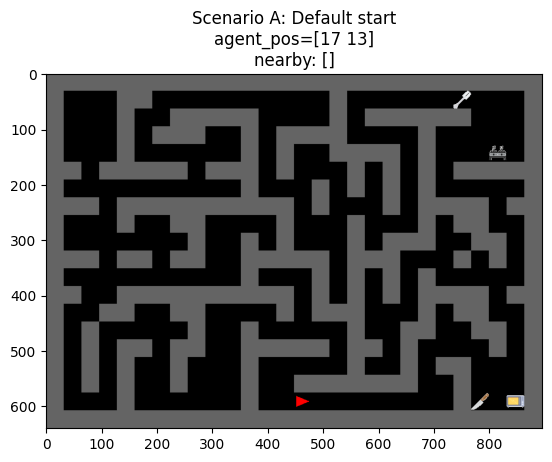

In [20]:
# Use first maze config
idx = 0
reset_params = jax.tree_util.tree_map(lambda x: jnp.asarray(x)[idx], train_env_params.reset_params)
reset_params = jax.tree_util.tree_map(lambda x: x[None], reset_params)
params = train_env_params.replace(reset_params=reset_params)

rng = jax.random.PRNGKey(0)
timestep = env.reset(rng, params)

obj_names = [image_data["keys"][int(o)] for o in task_objects]
state_obj_names = [image_data["keys"][int(o)] for o in timestep.state.objects]

print("Agent position:", timestep.observation.player_position)
print("task_objects:", list(zip(np.array(task_objects), obj_names)))
print("state.objects:", list(zip(np.array(timestep.state.objects), state_obj_names)))
print("nearby_objects:", timestep.observation.nearby_objects)
nearby_names = [obj_names[i] for i, v in enumerate(np.array(timestep.observation.nearby_objects)) if v]
print("nearby_names:", nearby_names)
print("object_positions:")
for i, (pos, name) in enumerate(zip(np.array(timestep.observation.object_positions), obj_names)):
  print(f"  {name}: {pos}")
print("task_w:", timestep.observation.task_w)
task_idx = int(jnp.argmax(timestep.observation.task_w))
print(f"target: {obj_names[task_idx]}")

image = render_maze(timestep)
plt.imshow(image)
plt.title(f"Scenario A: Default start\nagent_pos={np.array(timestep.observation.player_position)}\nnearby: {nearby_names}")
plt.show()

## Scenario B: Agent placed next to task object

task_w: [0. 1. 0. 0.]
Object positions:
  microwave: [17 25]
  stove: [ 3 24]
  fork: [ 0 22]
  knife: [17 23]
state.objects: [(40, 'stove'), (43, 'knife'), (47, 'fork'), (26, 'microwave')]
task_objects: [(26, 'microwave'), (40, 'stove'), (47, 'fork'), (43, 'knife')]

Task object index=1, object=stove (id=40)
Original agent_pos: [17 13]
New agent_pos:      [ 2 24]
nearby_objects: [0. 1. 1. 0.]
nearby_names: ['stove', 'fork']
state_features: [0. 0. 0. 0.]


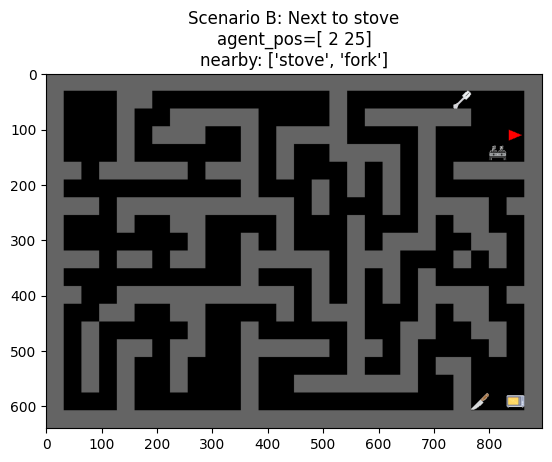

In [21]:
# Find task object position and place agent adjacent to it
obj_pos = timestep.observation.object_positions  # [D, 2]
task_w = timestep.observation.task_w
print("task_w:", task_w)
print("Object positions:")
for i, (pos, name) in enumerate(zip(np.array(obj_pos), obj_names)):
  print(f"  {name}: {pos}")
print("state.objects:", list(zip(np.array(timestep.state.objects), state_obj_names)))
print("task_objects:", list(zip(np.array(task_objects), obj_names)))

# Find the task object's position (the one with task_w=1)
task_idx = int(jnp.argmax(task_w))
target_pos = obj_pos[task_idx]
print(f"\nTask object index={task_idx}, object={obj_names[task_idx]} (id={task_objects[task_idx]})")

# Place agent 1 cell above the object (to stay in bounds)
new_agent_pos = jnp.array([target_pos[0] - 1, target_pos[1]], dtype=jnp.int32)
print(f"Original agent_pos: {np.array(timestep.state.agent_pos)}")
print(f"New agent_pos:      {np.array(new_agent_pos)}")

# Verify it's in-bounds
H, W = timestep.state.grid.shape[:2]
assert 0 <= int(new_agent_pos[0]) < H, f"y={int(new_agent_pos[0])} out of bounds (H={H})"
assert 0 <= int(new_agent_pos[1]) < W, f"x={int(new_agent_pos[1])} out of bounds (W={W})"

# Directly modify the state and recompute observation
modified_state = timestep.state.replace(agent_pos=new_agent_pos)
timestep_b = env.step(rng, timestep.replace(state=modified_state), jnp.array(0), params)

nearby_names_b = [obj_names[i] for i, v in enumerate(np.array(timestep_b.observation.nearby_objects)) if v]
print("nearby_objects:", timestep_b.observation.nearby_objects)
print("nearby_names:", nearby_names_b)
print("state_features:", timestep_b.observation.state_features)

image_b = render_maze(timestep_b)
plt.imshow(image_b)
plt.title(f"Scenario B: Next to {obj_names[task_idx]}\nagent_pos={np.array(timestep_b.observation.player_position)}\nnearby: {nearby_names_b}")
plt.show()

## Side-by-side comparison

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(image)
axs[0].set_title(f"A: Default start\nnearby: {nearby_names}")

axs[1].imshow(image_b)
axs[1].set_title(f"B: Next to object\nnearby: {nearby_names_b}")

plt.tight_layout()
plt.show()